<a href="https://colab.research.google.com/github/a-nagar/vistra-intermediate/blob/main/SARIMA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install statsmodels
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 12.8 MB/s eta 0:00:00


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

/tmp/ipython-input-516284169.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data.index = pd.date_range(start="1949-01-01", periods=len(data), freq="M")


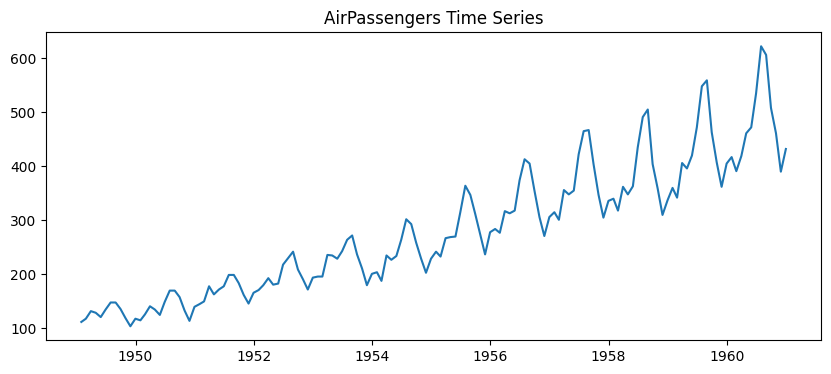

In [5]:
# ===========================
# 1. LOAD REAL DATASET
# ===========================
data = get_rdataset("AirPassengers").data
data.index = pd.date_range(start="1949-01-01", periods=len(data), freq="M")
ts = data['value']

plt.figure(figsize=(10,4))
plt.plot(ts)
plt.title("AirPassengers Time Series")
plt.show()


<Figure size 1200x400 with 0 Axes>

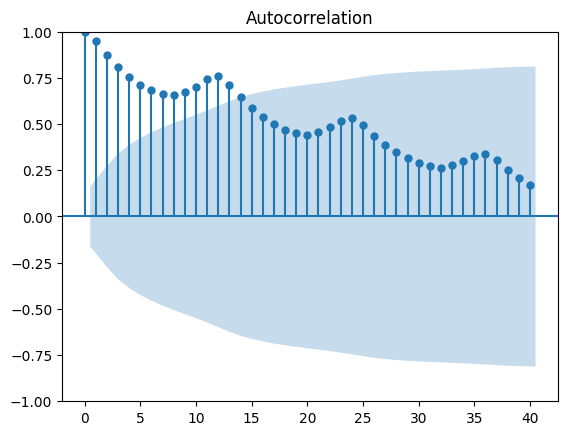

<Figure size 1200x400 with 0 Axes>

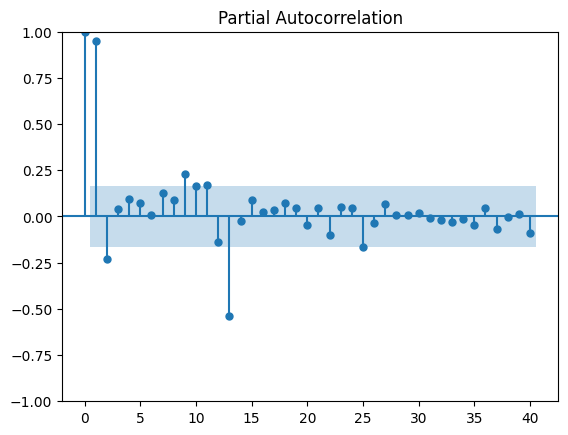

In [6]:
# ===========================
# 2. ACF & PACF for p, q analysis
# ===========================
plt.figure(figsize=(12,4))
plot_acf(ts, lags=40)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(ts, lags=40, method='ywm')
plt.show()

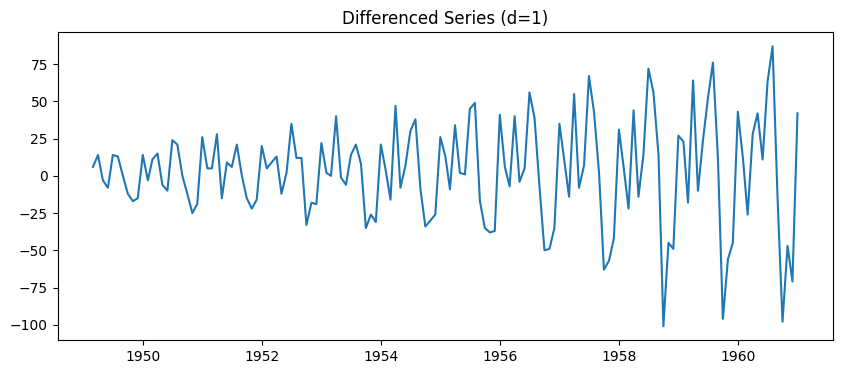

<Figure size 1200x400 with 0 Axes>

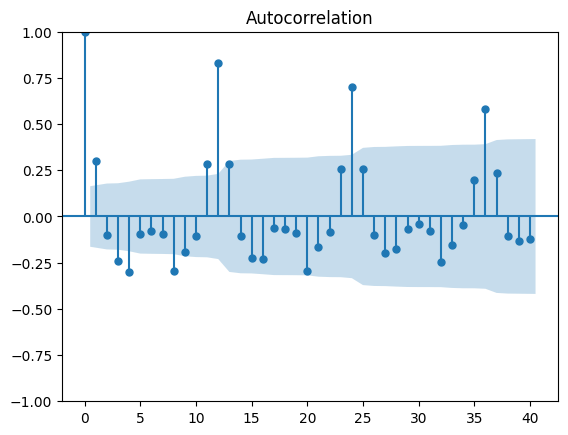

<Figure size 1200x400 with 0 Axes>

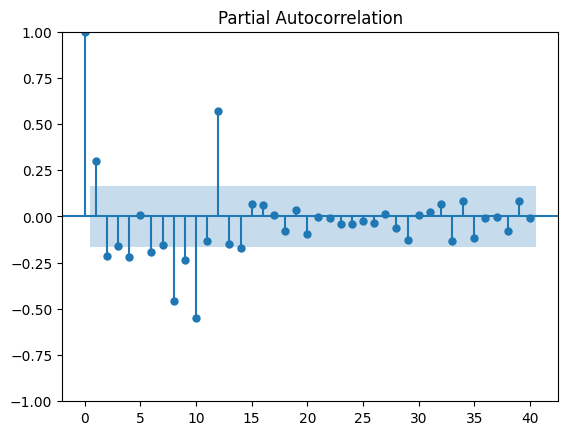

In [7]:
# ===========================
# 3. Check stationarity & differencing for d selection
# ===========================
ts_diff = ts.diff().dropna()

plt.figure(figsize=(10,4))
plt.plot(ts_diff)
plt.title("Differenced Series (d=1)")
plt.show()

plt.figure(figsize=(12,4))
plot_acf(ts_diff, lags=40)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(ts_diff, lags=40, method='ywm')
plt.show()

In [8]:
# ===========================
# 4. auto_arima for automatic model selection
# ===========================
stepwise = auto_arima(
    ts,
    seasonal=True,
    m=12,
    trace=True,
    suppress_warnings=True
)

print(stepwise.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=1.63 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.18 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=0.76 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=0.26 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=0.78 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=0.26 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.55 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=1.83 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=1.03 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=1.28 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.08 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.10 sec
 ARIMA(3,1,1)(0,1,0

In [9]:
# ===========================
# 5. Train-test split
# ===========================
train = ts.iloc[:-12]
test = ts.iloc[-12:]

In [10]:
# ===========================
# 6. Fit ARIMA (non-seasonal example)
#    Using auto_arima-selected order
# ===========================
p, d, q = stepwise.order
model_arima = ARIMA(train, order=(p, d, q))
fit_arima = model_arima.fit()

forecast_arima = fit_arima.forecast(steps=12)

In [13]:
# ===========================
# 7. Fit SARIMA (seasonal example)
# ===========================
P, D, Q, s = stepwise.seasonal_order
model_sarima = SARIMAX(train, order=(p, d, q),
                       seasonal_order=(P, D, Q, s))
fit_sarima = model_sarima.fit()

forecast_sarima = fit_sarima.forecast(steps=12)

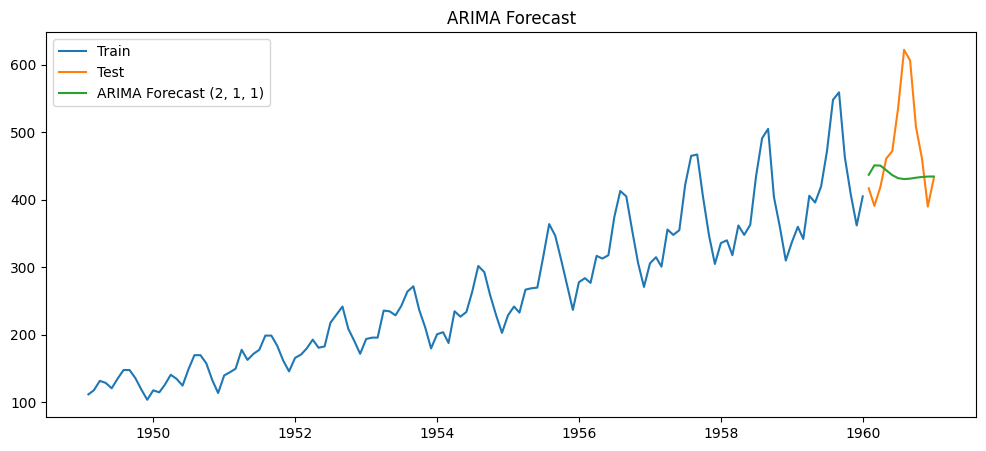

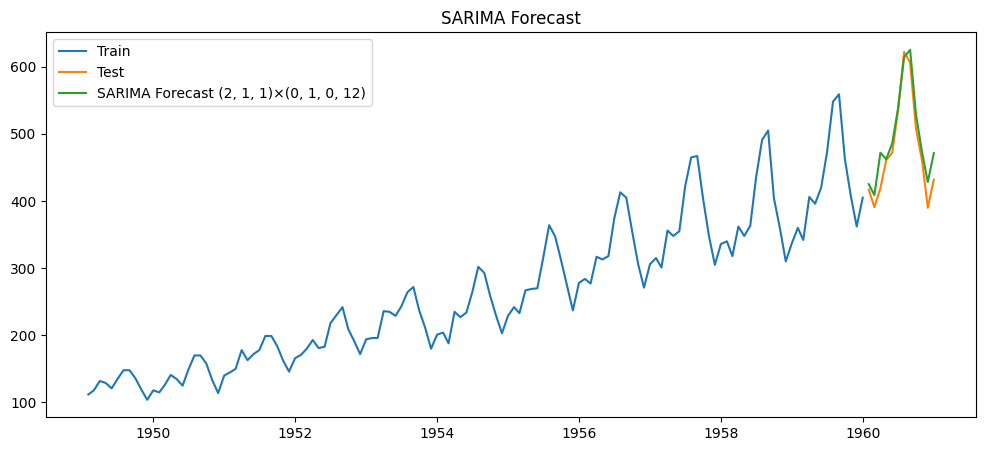

In [14]:
# ===========================
# 8. Visualization of forecasts
# ===========================
plt.figure(figsize=(12,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(forecast_arima, label=f"ARIMA Forecast {stepwise.order}")
plt.title("ARIMA Forecast")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(forecast_sarima, label=f"SARIMA Forecast {stepwise.order}×{stepwise.seasonal_order}")
plt.title("SARIMA Forecast")
plt.legend()
plt.show()

In [15]:
# ===========================
# 9. PERFORMANCE METRICS
# ===========================
def evaluate(true, pred, label):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = np.mean(np.abs((true - pred) / true)) * 100

    print(f"\n===== {label} Metrics =====")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

evaluate(test, forecast_arima, "ARIMA")
evaluate(test, forecast_sarima, "SARIMA")


===== ARIMA Metrics =====
MAE:  65.23
RMSE: 87.88
MAPE: 12.54%

===== SARIMA Metrics =====
MAE:  19.63
RMSE: 24.87
MAPE: 4.43%
